<a href="https://colab.research.google.com/github/mercury0925/AI-lab/blob/main/AIweek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Feature Extractions

In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.8.0+cu126
2.8.0+cu126


**Preparation**

In [2]:
!pip install librosa

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

file_path = "/content/drive/MyDrive/englishsentence.m4a"

waveform, sample_rate = torchaudio.load(file_path)


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    im = ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Power (dB)', rotation=270, labelpad=15)

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

**Spectrogram**

In [5]:
import torchaudio.transforms as T
# Define transform
spectrogram_transform = T.Spectrogram(n_fft=512)
# Perform transform
spec = spectrogram_transform(waveform)

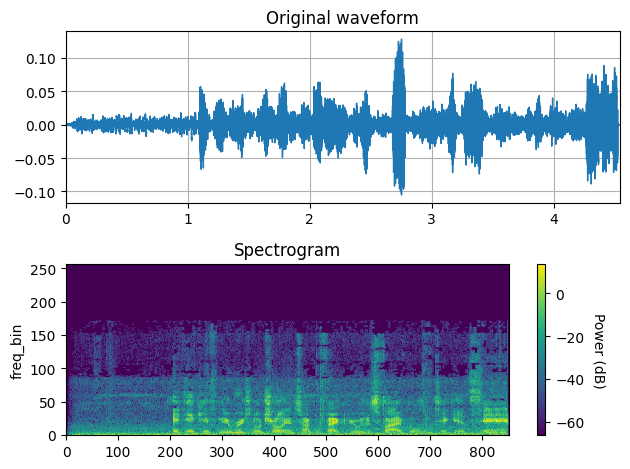

In [6]:
fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="Spectrogram", ax=axs[1])
fig.tight_layout()

In [7]:
Audio(waveform.numpy(), rate=sample_rate)

The effect of n_fft parameter

In [8]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(waveform)
    specs.append(spec)

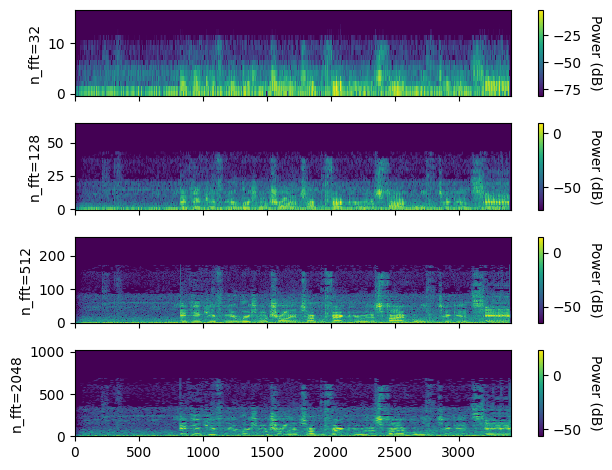

In [9]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

In [10]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(waveform, sample_rate, sample_rate // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, sample_rate // 2, sample_rate)

In [11]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(waveform)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

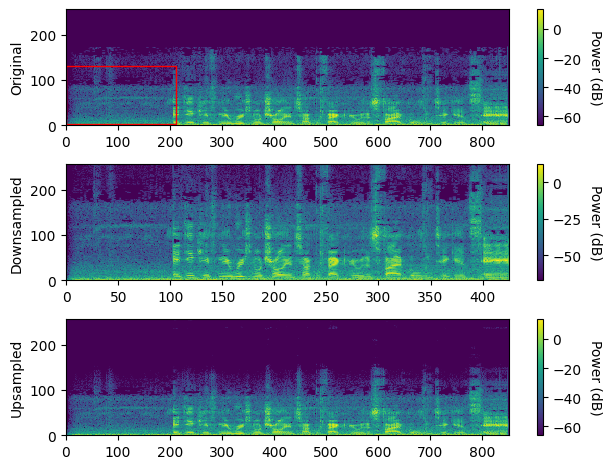

In [12]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

**GriffinLim**

In [13]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(waveform)
reconstructed_waveform = griffin_lim(spec)

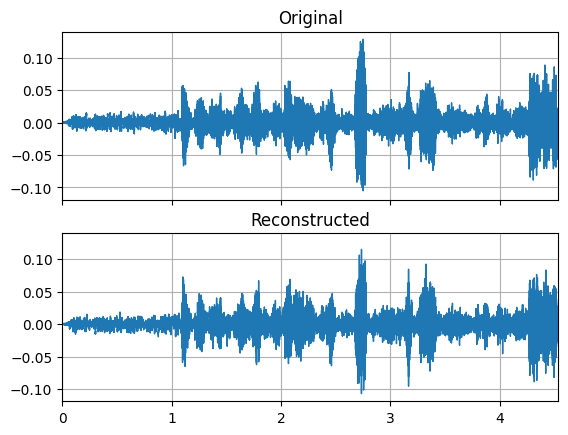

In [14]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(waveform, sample_rate, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, sample_rate, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=sample_rate)

Mel Filter Bank

In [15]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

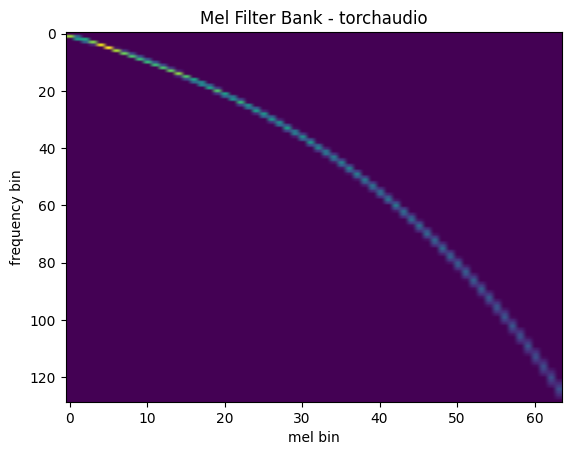

In [16]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Comparison against librosa

In [17]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

Mean Square Difference:  3.934872696751886e-17


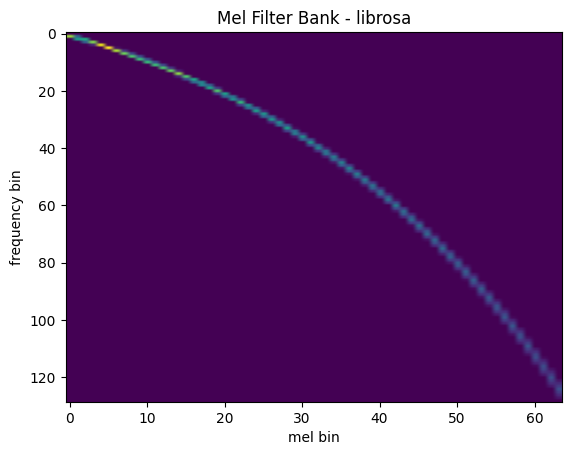

In [18]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

MelSpectrogram

In [19]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)

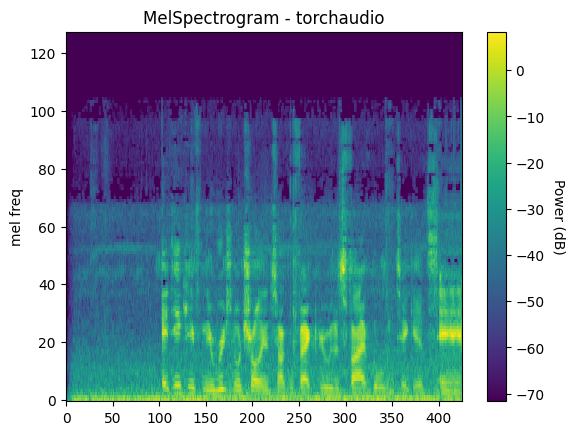

In [20]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

Comparison against librosa

In [21]:
melspec_librosa = librosa.feature.melspectrogram(
    y=waveform.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.1680780854280565e-13


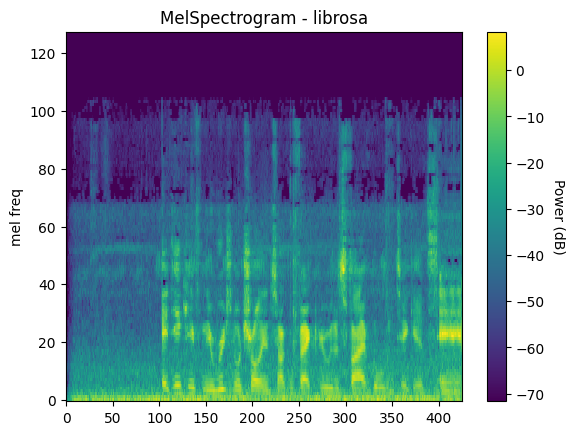

In [22]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

MFCC

In [23]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)

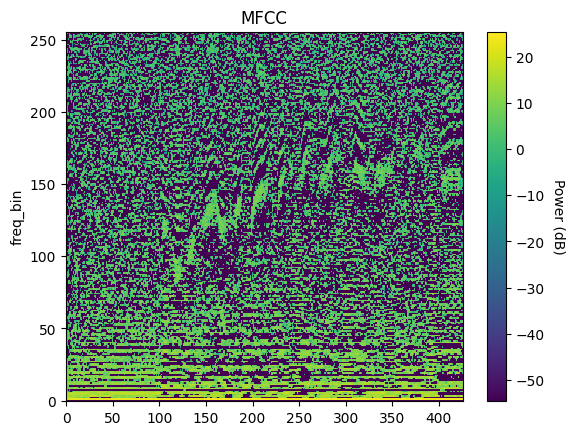

In [24]:
plot_spectrogram(mfcc[0], title="MFCC")

Comparison against librosa

In [25]:
melspec = librosa.feature.melspectrogram(
    y=waveform.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

Mean Square Difference:  0.003982788883149624


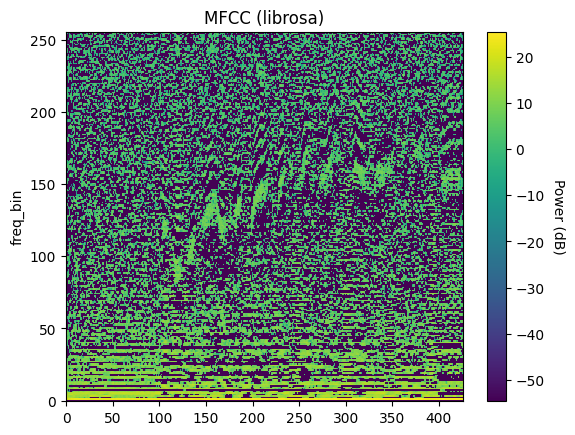

In [26]:
plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

LFCC

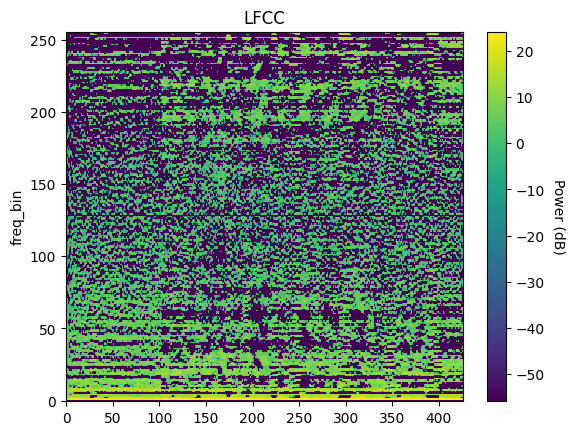

In [27]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(waveform)
plot_spectrogram(lfcc[0], title="LFCC")

Pitch

In [28]:
pitch = F.detect_pitch_frequency(waveform, sample_rate)

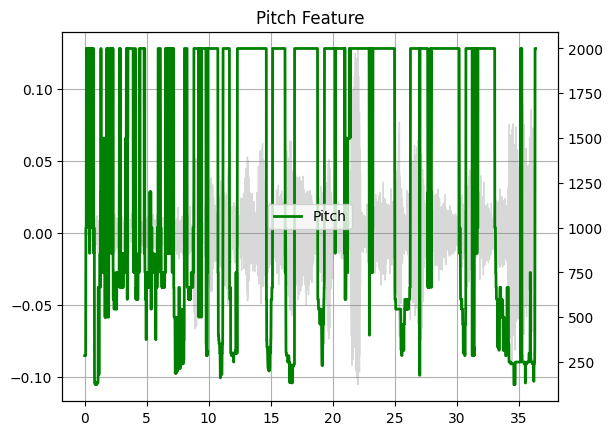

In [29]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(waveform, sample_rate, pitch)

# Speech Recognition with Wav2Vec2

In [30]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [31]:
import IPython
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

SPEECH_FILE = "/content/drive/MyDrive/englishsentence.m4a"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [33]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [34]:
IPython.display.Audio(SPEECH_FILE)

In [35]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [36]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

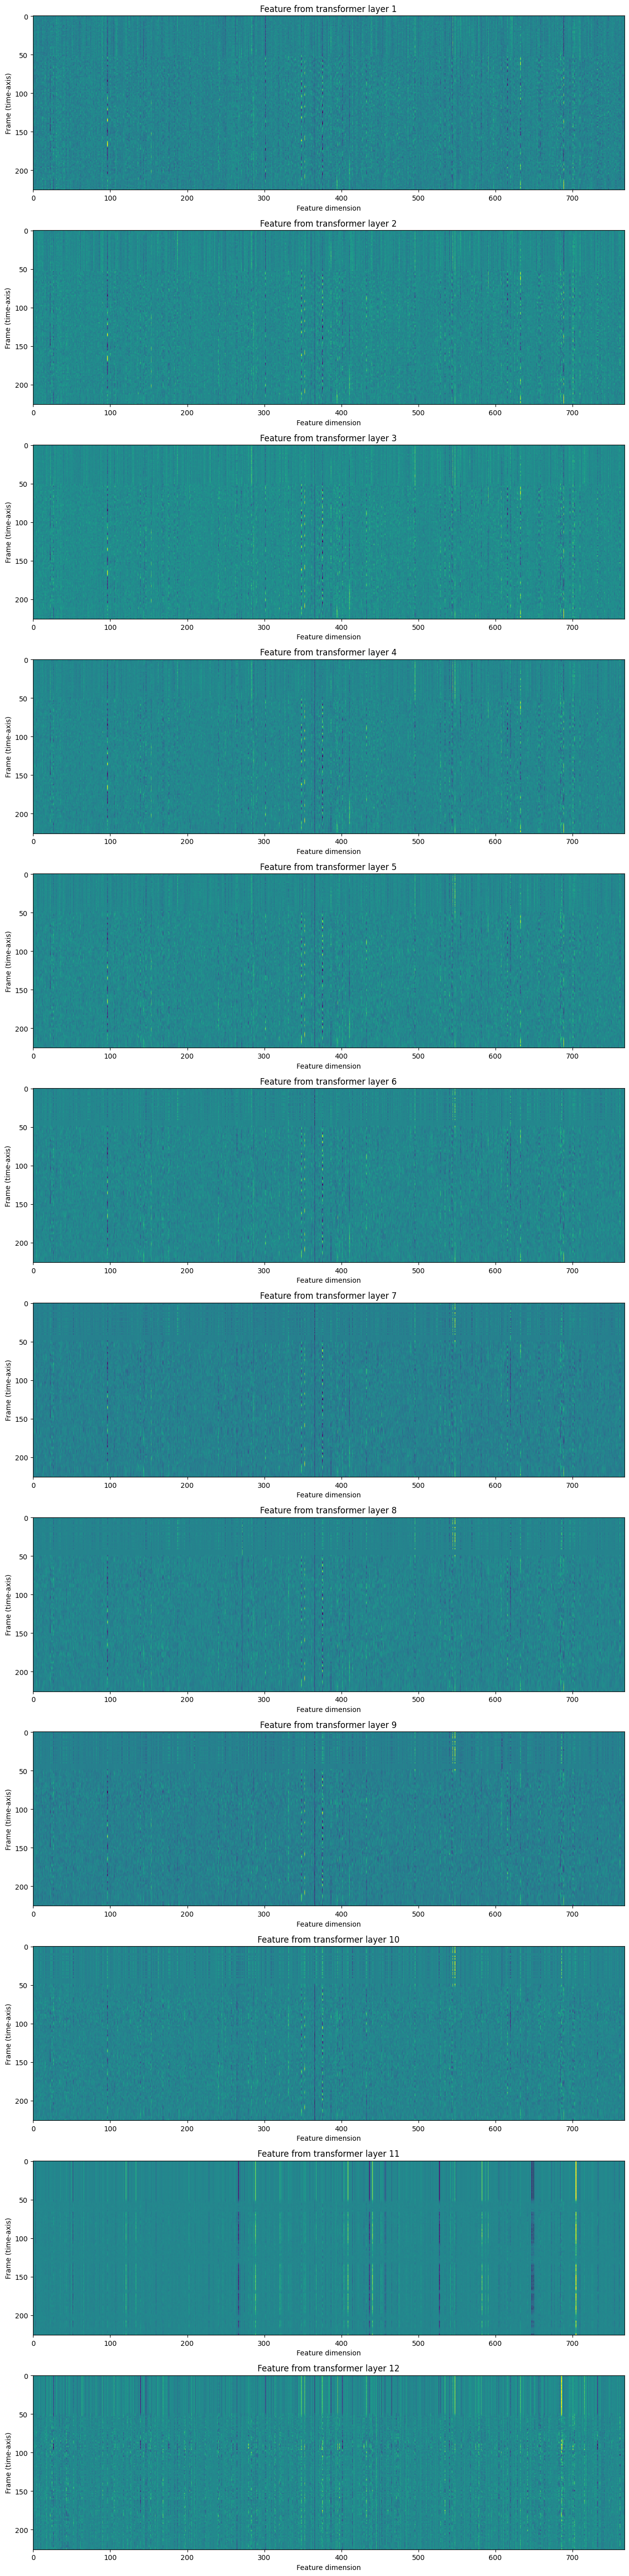

In [37]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [38]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


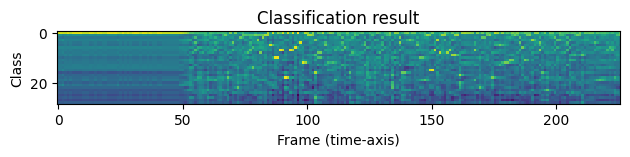

In [39]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [40]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [41]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [42]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

ADI|GAVE|HIM|THE|ORIGINAL|CHOYENCH|ON|TEVACTORY|WITH|HIS|FIVE|GOLD|AND|TICKET|SAYNIG|


-pyctcdecode를 활용해 Beam Search decoding으로 결과 정확도 개선

In [43]:
!pip install numpy==1.26.4 transformers datasets pyctcdecode
!pip install git+https://github.com/kensho-technologies/pyctcdecode.git

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from pyctcdecode import build_ctcdecoder

model_id = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id).to(device)

input_values = processor(waveform.squeeze().cpu().numpy(), sampling_rate=16000, return_tensors="pt").input_values.to(device)

with torch.no_grad():
    logits = model(input_values).logits

vocab = processor.tokenizer.get_vocab()
sorted_vocab = [k for k,v in sorted(vocab.items(), key=lambda item: item[1])]
decoder = build_ctcdecoder(sorted_vocab)

beam_result = decoder.decode(logits.cpu().numpy()[0])
print("Beam Search Result:", beam_result)

  Cloning https://github.com/kensho-technologies/pyctcdecode.git to /tmp/pip-req-build-kixnbh50
  Running command git clone --filter=blob:none --quiet https://github.com/kensho-technologies/pyctcdecode.git /tmp/pip-req-build-kixnbh50
  Resolved https://github.com/kensho-technologies/pyctcdecode.git to commit afecb67622c1395b85b6a55d2902a780c0c927d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Beam Search Result: A A CAVE FROM THE ORIGINAL CHOLLIIN SOCEF FACTOR WITH HIS FIVE GOLD AND TACKET SAYIN


오디오 전처리(정규화 + 리샘플링 + 무음제거) -> Wav2Vec2 모델을 사용해 Greedy decoding

In [44]:
import torch
import torchaudio

waveform, sample_rate = torchaudio.load(SPEECH_FILE)

waveform = waveform / waveform.abs().max()

if sample_rate != 16000:
    waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)
    sample_rate = 16000

waveform = torchaudio.functional.vad(waveform, sample_rate=sample_rate)

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()

with torch.inference_mode():
    emission, _ = model(waveform.to(device))

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank
    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

decoder = GreedyCTCDecoder(labels)
transcript = decoder(emission[0])
print("Greedy + 전처리 Transcript:", transcript.replace("|"," "))


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Greedy + 전처리 Transcript: I DI GIE OM THE ORIGINAL CHALLY IN SOK OF FACTOR WITH HIS FI GLE AND TAKET AT SAN 


-HuggingFace의 pipeline을 이용, OpenAI Whisper 모델(whisper-small.en)

In [45]:
!pip install transformers

from transformers import pipeline

asr = pipeline("automatic-speech-recognition", model="openai/whisper-small.en")

result = asr(SPEECH_FILE)
print("Whisper Transcript:", result["text"])

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.


Whisper Transcript:  A DK from the original charlie and chocolate factory with his five golden tickets and
